# Validation of assumption that spatially close cells have more similar transcriptomes

One of the underlying assumptions of TISSUE is that all else being equal, spatial neighbors will tend to have more similar transcriptomes than non-neighbors. We test this across the eleven benchmark datasets and also test whether similarity on a subset of genes can generalize to similarity on unseens genes.

The notebook requires having the dataset folders formatted and in "DataUpload" top-level directory in the current working directory. The data can be retrieved from the Zenodo repository in our manuscript (DOI: 10.5281/zenodo.8259942).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from TISSUE.tissue.main import *

In [4]:
dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC\n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)"}

## Final Figure

In [3]:
# set up df
comb_df = pd.DataFrame([])
num_rand_draws = 250 # number of cells to use (will compare all neighbors and random matches per cell)

for dataset_name in ["Dataset3", "Dataset9", "Dataset11", "Dataset12",
                     "Dataset13", "Dataset14", "Dataset15", "Dataset17",
                     "Dataset1", "Dataset7", "Axolotl"]:
    
    # load anndata object
    adata = load_spatial_data (f"DataUpload/{dataset_name}/Spatial_count.txt",
                                 f"DataUpload/{dataset_name}/Locations.txt",
                                 spatial_metadata=None)
    
    # build spatial graph
    build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
    
    # get near cells and compare expression similarity (random cells as control)
    np.random.seed(444)
    rand_idxs = np.random.choice(np.arange(len(adata.obs_names)), num_rand_draws, replace=False)

    cos_sims_near = []
    cos_sims_rand = []

    for oi in rand_idxs:
        for ni in range(len(adata.obs_names)):
            if (adata.obsp['spatial_connectivities'][oi,ni]==1) and (ni!=oi):
                
                # compute cosine similarity for the neighbor cells
                r = 1-cosine(np.array(adata[oi,:].X).flatten(),
                                 np.array(adata[ni,:].X).flatten())
                cos_sims_near.append(r)
                
                # draw random cells for matched comparison group
                ri = np.random.choice(np.arange(len(adata.obs_names)), 1)
                # compute cosine similarity for the neighbor cells
                r = 1-cosine(np.array(adata[oi,:].X).flatten(),
                               np.array(adata[ri,:].X).flatten())
                cos_sims_rand.append(r)
                
    # make dataframe for results
    df = pd.DataFrame(np.vstack([[cos_sims_near+cos_sims_rand],
                   ["Neighbor"]*len(cos_sims_near)+["Random"]*len(cos_sims_rand)]).T,
                   columns=["Cosine Similarity", "Comparison"])
    df["Cosine Similarity"] = df["Cosine Similarity"].astype(float)
    df["Dataset"] = dataset_mapper[dataset_name]
    
    comb_df = pd.concat((comb_df, df))

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/.conda/e

In [4]:
# save results for later
comb_df.to_csv("spatial_proximity_assumption_results_df.csv",index=False)

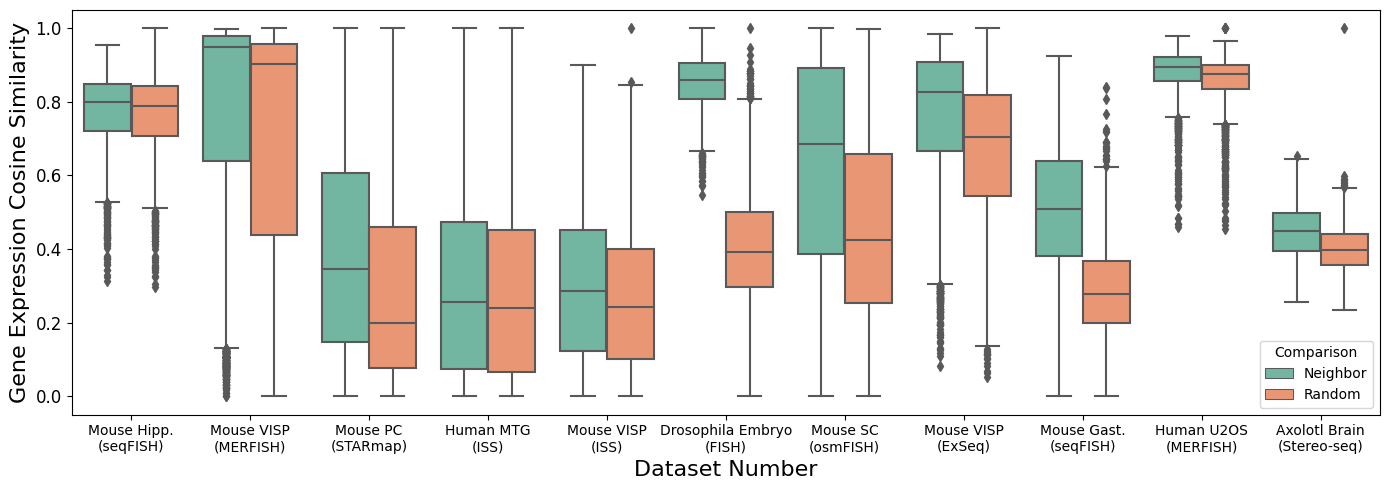

In [6]:
# generate box plots to show distribution of cosine similarities
plt.figure(figsize=(14,5))
sns.boxplot(data=comb_df, x="Dataset", y="Cosine Similarity", hue='Comparison', palette="Set2")
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.ylabel("Gene Expression Cosine Similarity", fontsize=16)
plt.xlabel("Dataset Number", fontsize=16)
plt.tight_layout()
plt.savefig("plots/FINAL_proximity_cosine_expression_boxplot.pdf",bbox_inches='tight')

### On datasets with many genes, similarity of expression on a subset of genes is indicative of similarity of expression on unseen genes for neighboring cells

In [6]:
# for adjacent cells, expression is correlated

comb_df = pd.DataFrame([])
num_rand_draws = 250 # number of cells to sample per dataset for this task (will take all neighbors)
hold_out_ratio = 0.5 # train-test splitting ratio of subsets

for dataset_name in ["Dataset7", "Axolotl"]:
    
    # load anndata object
    adata = load_spatial_data (f"DataUpload/{dataset_name}/Spatial_count.txt",
                                 f"DataUpload/{dataset_name}/Locations.txt",
                                 spatial_metadata=None)
    
    # build spatial graph
    build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
    
    np.random.seed(444)
    for seed in np.random.randint(1,1000,10):

        # split genes
        np.random.seed(seed)
        test_genes = np.random.choice(np.array(adata.var_names), round(adata.shape[1]*hold_out_ratio), replace=False)
        train_genes = np.array([g for g in adata.var_names if g not in test_genes])

        # get near cells and compare expression similarity (random cells as control)
        np.random.seed(444)
        rand_idxs = np.random.choice(np.arange(len(adata.obs_names)), num_rand_draws, replace=False)

        cos_sims_near_train = []
        cos_sims_near_test = []

        for oi in rand_idxs:
            for ni in range(len(adata.obs_names)):
                if (adata.obsp['spatial_connectivities'][oi,ni]==1) and (ni!=oi):
                    
                    # compute cosine similarity for the train subset
                    r = 1-cosine(np.array(adata[oi,train_genes].X).flatten(),
                                     np.array(adata[ni,train_genes].X).flatten())
                    cos_sims_near_train.append(r)
                    
                    # compute cosine similarity for the test (unseen) subset
                    r = 1-cosine(np.array(adata[oi,test_genes].X).flatten(),
                                     np.array(adata[ni,test_genes].X).flatten())
                    cos_sims_near_test.append(r)

        # make dataframe for results
        df = pd.DataFrame([])
        df["Cosine Similarity (Train)"] = cos_sims_near_train
        df["Cosine Similarity (Test)"] = cos_sims_near_test
        df["Dataset"] = dataset_mapper[dataset_name]
        df["Seed"] = seed

        comb_df = pd.concat((comb_df, df))

/home/edsun/anaconda3/envs/merfish/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/merfish/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/anaconda3/envs/merfish/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/merfish/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


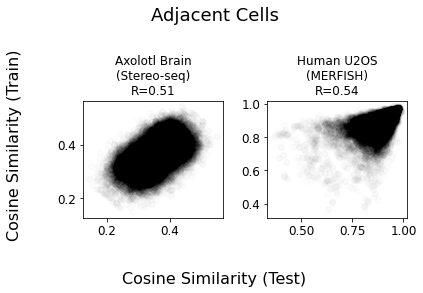

In [7]:
# Make scatter plots between the train and unseen (test) cosine similarities

fig, axs = plt.subplots(1, len(np.unique(comb_df["Dataset"])),  sharex=False, sharey=False, figsize=(6, 4))

for i, dataset in enumerate(np.unique(comb_df["Dataset"])):
    sub_df = comb_df[comb_df["Dataset"]==dataset]
    axs[i].scatter(sub_df["Cosine Similarity (Train)"], sub_df["Cosine Similarity (Test)"], c='k', alpha=0.01, rasterized=True)
    
    r,p = pearsonr(sub_df["Cosine Similarity (Train)"], sub_df["Cosine Similarity (Test)"])
    
    axs[i].set_title(f"{dataset}\nR={round(r,2)}")
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].tick_params(axis='both', which='minor', labelsize=12)

fig.suptitle("Adjacent Cells", fontsize=18)
fig.supylabel("Cosine Similarity (Train)", fontsize=16)
fig.supxlabel("Cosine Similarity (Test)", fontsize=16)
plt.tight_layout(pad=1.8)
plt.savefig("plots/FINAL_proximity_nearby_heldout_correlation_manygenesOnly_50_50.pdf",bbox_inches='tight',dpi=300)
plt.show()